# Sandbox notebook for data analysis and visualization

Author: Veikka Immonen

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import cv2
import scipy
import math
import random

from pathlib import Path
import glob
from collections import Counter
from PIL import Image
import re
from itertools import batched

from src import data
import cv2
import torch
from torchvision.transforms import v2

from tqdm import tqdm

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

from sklearn.model_selection import train_test_split

plt_original_resolution = plt.rcParams['figure.figsize']
plt_original_resolution

[3.5, 2.625]

## CytoSense

In [2]:
data_dir = Path('./data/FASTVISION-plus')
annotations = pd.read_csv(data_dir / 'annotations.csv')
annotations, len(annotations)

def to_latin(key):
    key_new = key.replace('-', '_')
    pieces = key_new.split('_')
    if len(pieces) == 1:
        title = f'$\\it{{{key}}}$'
    else:
        title = ('$\\it{{{}}}$ ' * len(pieces)).format(*pieces)[:-1]
    title = title.replace('$\\it{sp}$', 'sp.')
    return title

### Statistics

Number of samples for each instance, how many of them are purely multimodal 
(images + all time series data)?

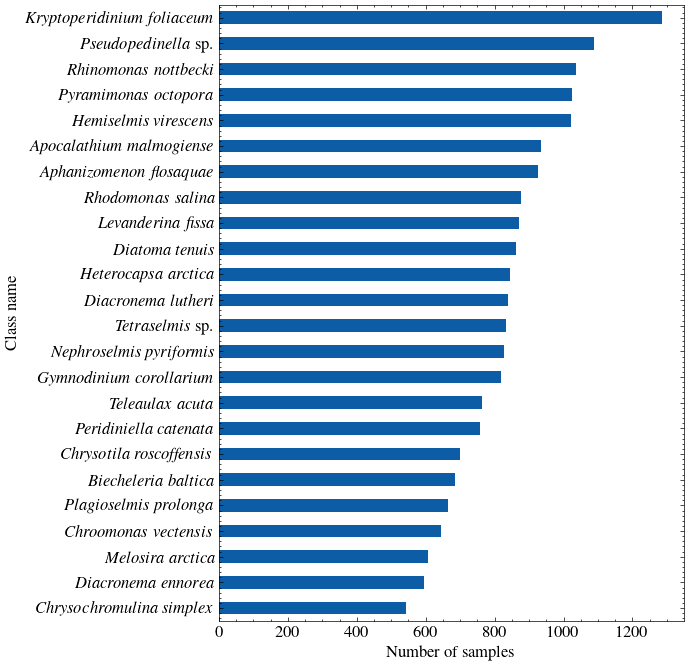

In [254]:
counter = Counter(annotations['class'])

for key in list(counter.keys()):
    title = to_latin(key)
    counter[title] = counter[key]
    del counter[key]
    

df = pd.DataFrame(
    data=counter.values(),
    index=counter.keys(),
).sort_values(0)

df.plot(kind='barh', figsize=(6, 8), legend=False)

plt.xlabel('Number of samples')
plt.ylabel('Class name')

# plt.savefig(f'figures/sample_counts.pdf')
# plt.xscale('log')
plt.show()

In [255]:
df.sum()

0    20050
dtype: int64

Rough selection would be to exclude classes with less than 10 multimodal samples.

### Visualization

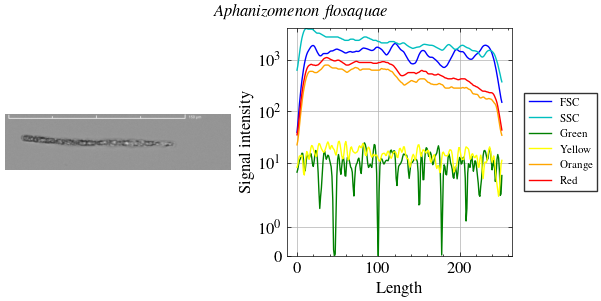

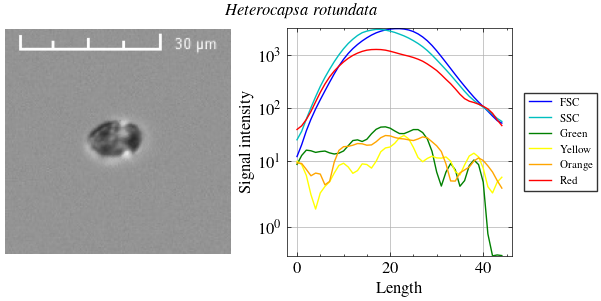

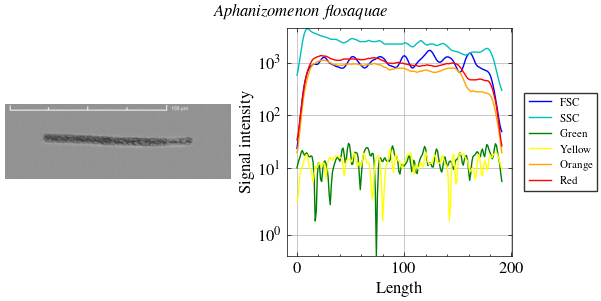

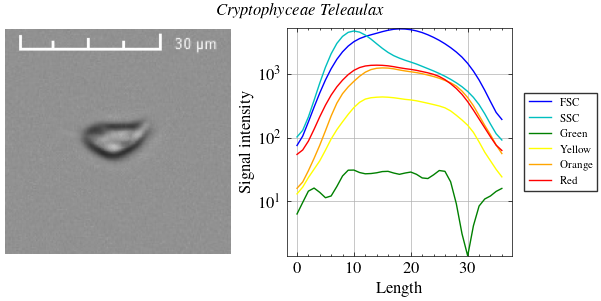

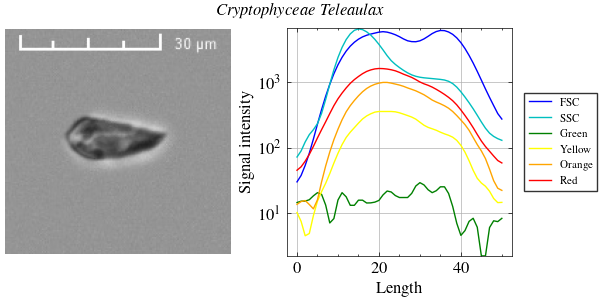

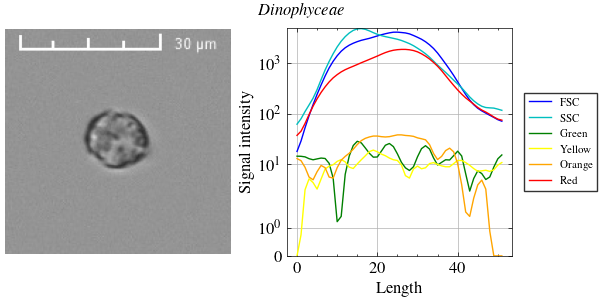

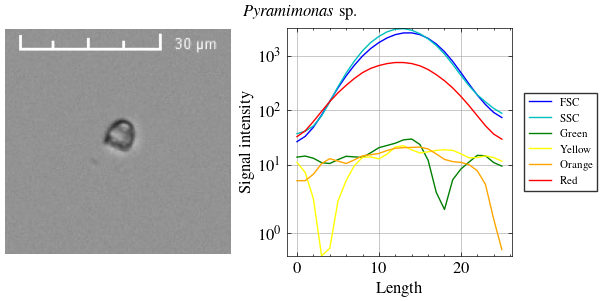

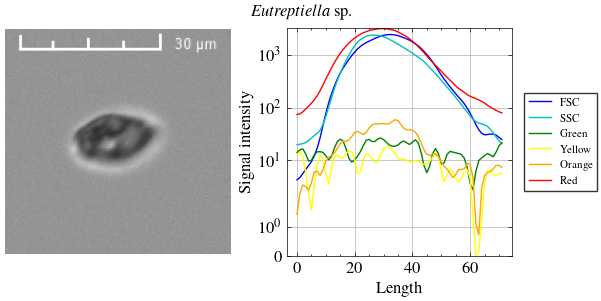

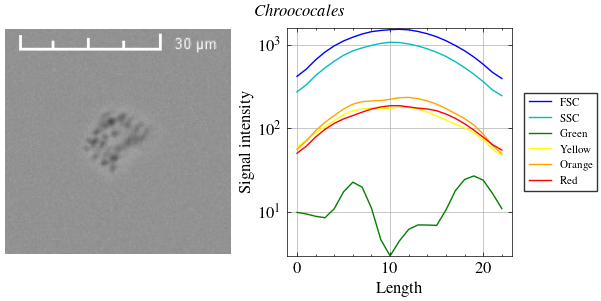

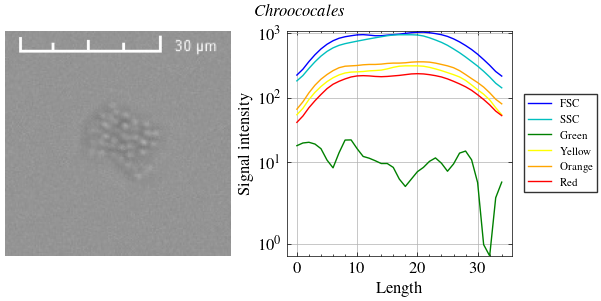

In [16]:
np.random.seed(1)


def visualize(sample):
    image = np.array(Image.open(data_dir / f"{sample.image}"))
    profile = pd.read_csv(data_dir / f"{sample.profile}")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)))
    ax2.legend(loc=7, frameon=True, edgecolor='k', fancybox=False, bbox_to_anchor=(1.4, 0.5), fontsize=8)
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Signal intensity')
    ax2.set_yscale('symlog')
    ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(6, 3)

    name = sample['class']
    title = to_latin(name)
    
    plt.grid()
    plt.suptitle(title, fontsize=12)
    plt.savefig(f'figures/{sample['class']}.pdf')
    plt.show()

for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(10).iterrows():
    visualize(sample)



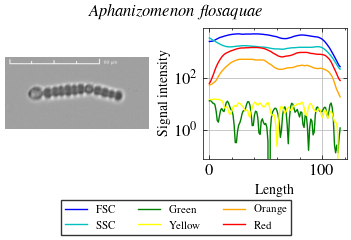

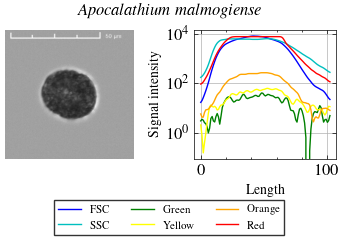

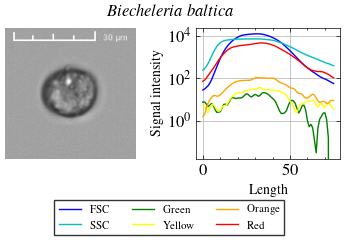

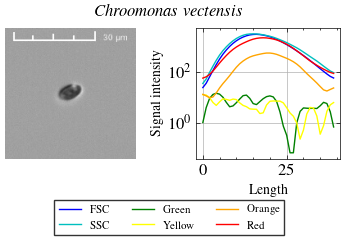

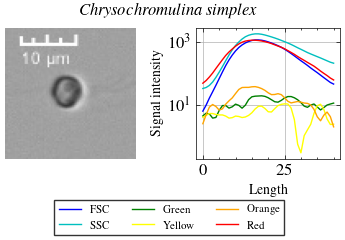

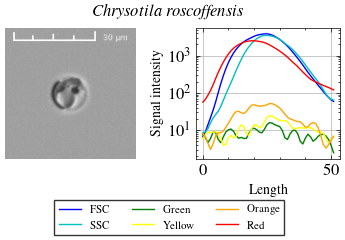

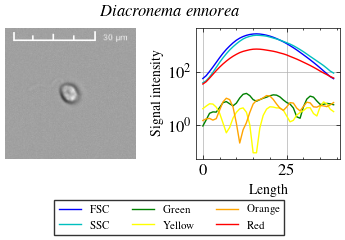

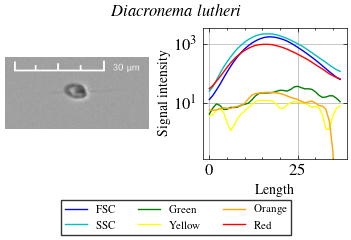

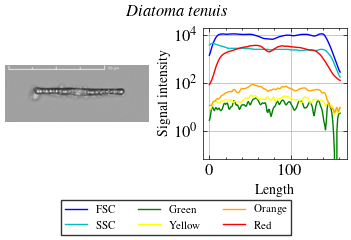

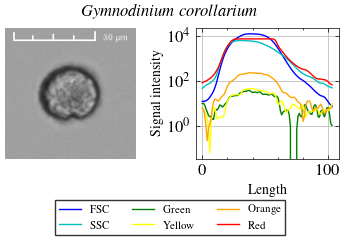

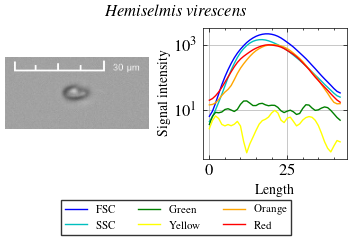

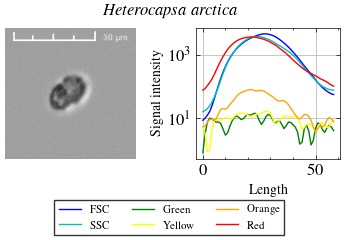

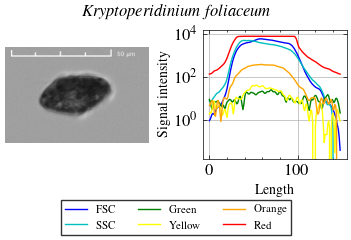

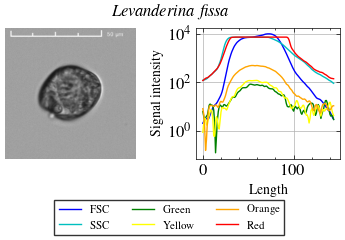

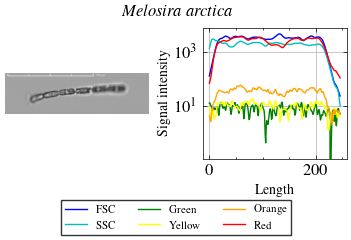

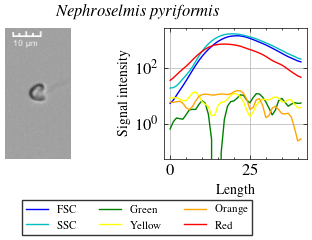

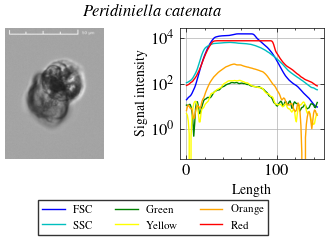

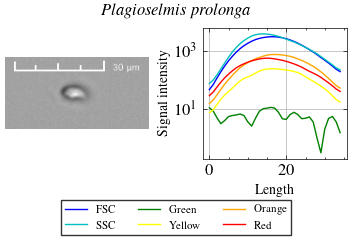

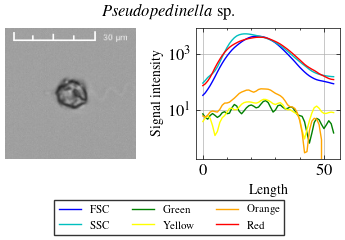

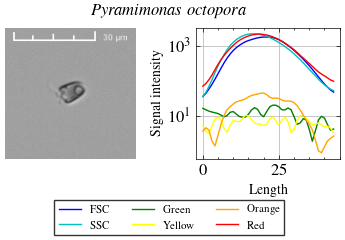

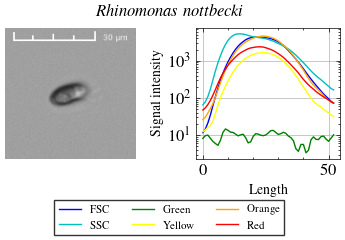

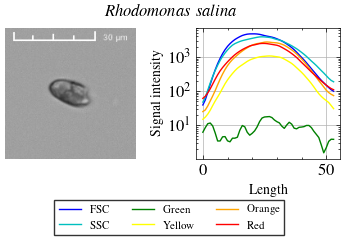

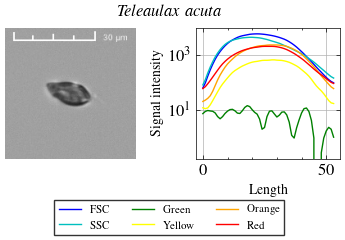

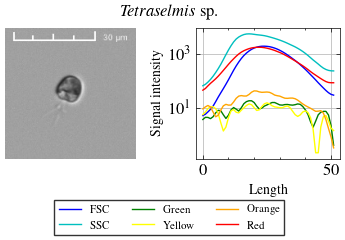

In [23]:
def visualize(sample):
    image = np.array(Image.open(data_dir / f"{sample.image}"))
    profile = pd.read_csv(data_dir / f"{sample.profile}")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)), legend=None)
    fig.legend(loc=8, ncols=3, frameon=True, edgecolor='k', fancybox=False, fontsize=8, bbox_to_anchor=(.5, -.2))
    ax2.set_xlabel('Length', fontsize=10)
    ax2.set_ylabel('Signal intensity', fontsize=10)
    ax2.set_yscale('log')
    # ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(3.5, 2)
    
    title = to_latin(name) 
    
    plt.grid()
    plt.suptitle(title, fontsize=12)
    plt.savefig(f'figures/small_{sample['class']}.pdf')
    plt.show()

for name in annotations['class'].unique():
    for _, sample in annotations[annotations['class'] == name].sample(1).iterrows():
        visualize(sample)



In [3]:
profiles = map(lambda p: data_dir / p, tqdm(annotations.profile.to_list()))
dfs = map(pd.read_csv, profiles)
arrs = list(map(len, dfs))
P = Counter(arrs)

100%|██████████| 9353/9353 [00:05<00:00, 1718.21it/s]


In [4]:
max(arrs)

998

In [6]:
from src.data import resize_profile

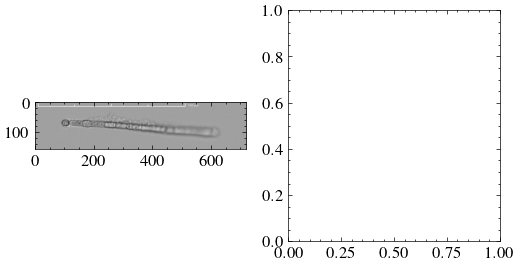

In [256]:
i = np.argsort(arrs)[::-1][0].item()
foo = annotations.profile.to_list()
bar = annotations.image.to_list()
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(Image.open(data_dir / bar[i]))
prof = pd.read_csv(data_dir / foo[i])
# cols = prof.columns
# data = np.log(1 + prof.to_numpy())
# data = resize_profile(torch.tensor(data)).numpy()
# prof = pd.DataFrame(data=data, columns=cols)
# prof = prof.iloc[(prof != 0).all(1).to_numpy()]
# prof.plot(ax=ax2)
# plt.xscale('log')

In [59]:
i = np.argsort(arrs)[::-1][0].item()
prof = pl.read_csv(data_dir / foo[i])
prof.filter(*(pl.col(c) > 0 for c in prof.columns))

FSC,SSC,Green,Yellow,Orange,Red
f64,f64,f64,f64,f64,f64
3.792,5.792,6.833,3.125,17.83,17.83
6.188,7.594,6.656,4.875,21.5,20.75
11.59,13.16,5.625,6.313,28.129999,26.129999
22.219999,24.940001,4.281,5.594,33.380001,33.630001
43.560001,47.630001,4.625,3.656,35.5,44.5
…,…,…,…,…,…
28.75,54.25,3.844,1.656,51.0,36.630001
22.84,38.630001,2.719,2.125,43.0,29.129999
19.780001,29.379999,1.531,2.781,34.880001,21.440001


In [26]:
(prof == 0).all(1).to_numpy()

array([False, False, False, ...,  True,  True,  True], shape=(12226,))

In [36]:
mu, std = P.mean(0), P.std(0)
mu, std

(array([5.25559349, 5.38631283, 1.81696798, 2.04520757, 3.21565379,
        5.5010403 ]),
 array([3.39987335, 3.18043695, 1.19167829, 1.55065274, 2.31663113,
        3.16980979]))

(169, 6)


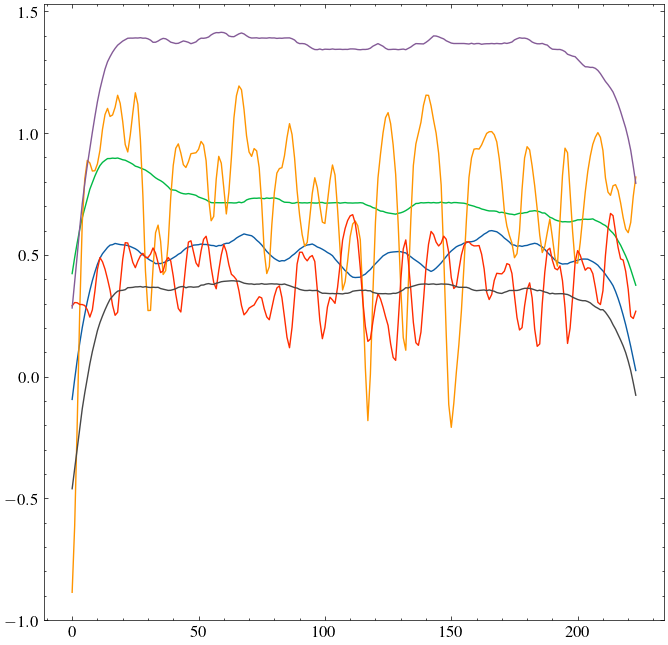

In [140]:
prof = pd.read_csv(data_dir / foo[1500])
profile = prof.to_numpy()
print(profile.shape)

pt = v2.Compose((
    lambda x: torch.tensor(x).float().add(1).log().t().unsqueeze(1),
    v2.Normalize([5.256, 5.386, 1.817, 2.045, 3.216, 5.501],
                 [3.400, 3.180, 1.192, 1.551, 2.317, 3.170]),
    v2.Resize((1, 235)),
    v2.RandomCrop((1, 224)),
    lambda x: x + 1e-3 * torch.randn_like(x),
    lambda x: x.squeeze(1).t()
))

_, ax = plt.subplots(figsize=(8, 8))

for p in pt(profile).T:
    ax.plot(p)

240
tensor(-5.8302) tensor(1.6932) tensor(-0.5031) tensor(1.5939)


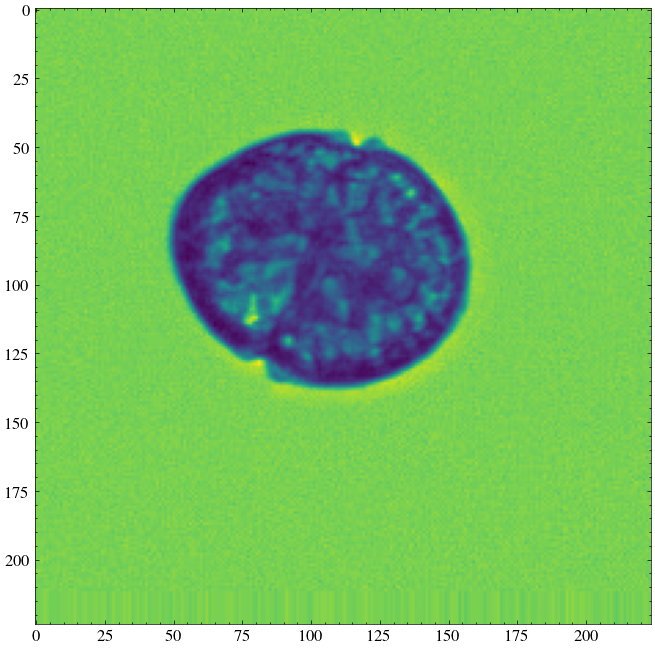

In [260]:
from src.data import resize_pil

img = Image.open(data_dir / bar[1000])
print(img.height)

it = v2.Compose((
    lambda x: x.crop((0, 25, x.width, x.height)),
    lambda x: resize_pil(x, 240, edge=True),
    v2.ToImage(),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.6136], [0.0938]),
    v2.RandomCrop((224, 224)),
    v2.RandomVerticalFlip(),
    lambda x: x + 1e-3 * torch.randn_like(x),
))

_, ax = plt.subplots(figsize=(8, 8))

out = it(img)

print(out.min(), out.max(), out.mean(), out.std())

ax.imshow(out[0])


In [37]:
foo = (P - mu) / std
foo.mean(0), foo.std(0)

(array([ 1.24422572e-16,  2.65448076e-17, -8.93153241e-16,  4.29426885e-16,
         4.55611300e-16,  9.67841581e-16]),
 array([1., 1., 1., 1., 1., 1.]))

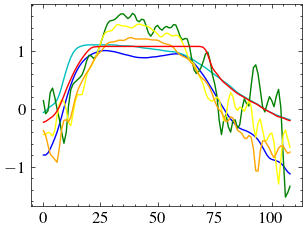

In [39]:
foo = annotations.profile.to_list()
norm = v2.Normalize(mu, std)
profile = torch.tensor(np.loadtxt(data_dir / foo[1500], delimiter=',', skiprows=1)).T
profile = profile.add(1).log().unsqueeze(1)

x = norm(profile).squeeze(1)
styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

_, ax = plt.subplots()
for p, c in zip(x, styles):
    ax.plot(p, color=c) 

In [249]:
images = map(lambda i: data_dir / i, tqdm(annotations.image.to_list()))
dfs = map(Image.open, images)
arrs = map(lambda x: x.convert('L'), dfs)
arrs = map(v2.functional.to_image, arrs)
arrs = map(lambda x: v2.functional.to_dtype(x, scale=True), arrs)
arrs = map(lambda x: x.permute(1, 2, 0).flatten(0, 1), arrs)
pixels = torch.cat(list(arrs))

100%|██████████| 20050/20050 [00:15<00:00, 1336.16it/s]


In [250]:
pixels.mean(0), pixels.std(0)

(tensor([0.6136]), tensor([0.0938]))

In [3]:
image_transform = data.ImageTransformTrain(224)
profile_transform = data.ProfileTransformTrain(224)
pair_augment = data.PairAugmentationNew()

dataset = data.MultiSet(data_dir / 'fold1/train.csv', image_transform,
                        profile_transform, pair_augment)

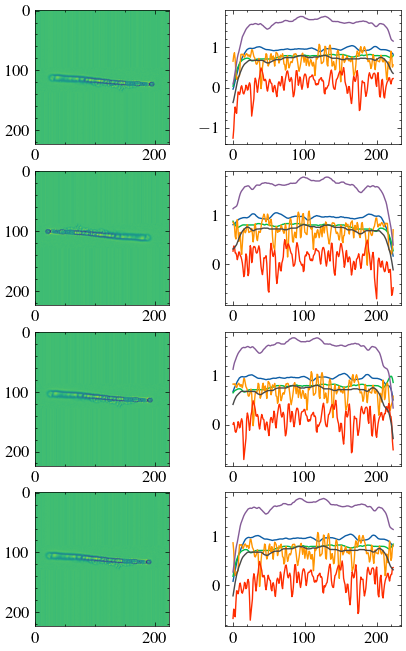

In [15]:
_, ax = plt.subplots(4, 2, figsize=(5, 8))

for ax1, ax2 in ax:
    sample = dataset[0]
    ax1.imshow(sample['image'][0])
    for p in sample['profile'].T:
        ax2.plot(p)

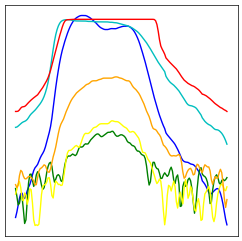

In [ ]:
    
for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample().iterrows():
    x = sample.ID

    image = Image.open(image_dir / f"{x}.jpg")
    profile = pd.read_csv(profile_dir / f"{x}.csv")
    profile = np.log(profile + 1)

    h, w = image.size

    if h == w:
        styles = ['b', 'c', 'g', 'yellow', 'orange', 'r']

        fig, ax = plt.subplots(figsize=(3, 3))
        ax = profile.plot(ax=ax, style=dict(zip(profile.columns, styles)))

        ax.legend().set_visible(False)
    
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.savefig(f'figures/{x}_profile.jpg')
        image = image.resize((256, 256))
        image.save(f'figures/{x}_image.jpg')

        plt.show()


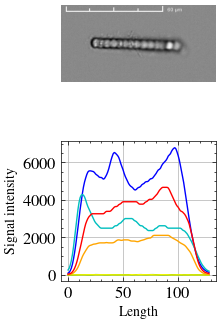

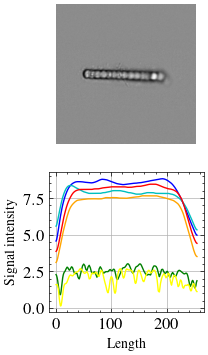

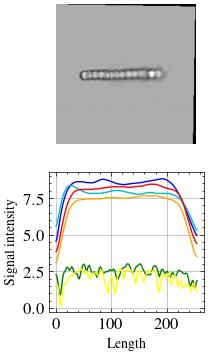

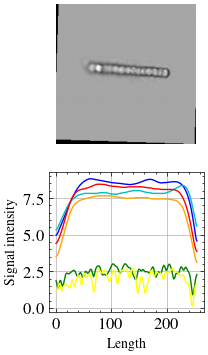

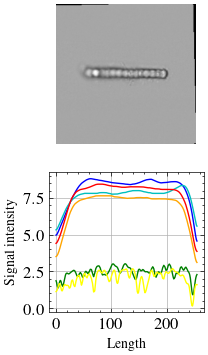

In [9]:
from src import data
import cv2
import torch

sample = annotations.iloc[243]

image = cv2.imread(image_dir / f'{sample.ID}.jpg', cv2.IMREAD_GRAYSCALE)
profile = np.loadtxt(profile_dir / f'{sample.ID}.csv', delimiter=',', skiprows=1)  
profile = torch.tensor(profile)

img_tr = data.ImageTransforms()
prf_tr = data.ProfileTransform(max_len=256)
pair_tr = data.PairAugmentation()

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
for feature, color in zip(profile.T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
    ax2.plot(feature, color=color)
ax2.set_xlabel('Length', fontsize=10)
ax2.set_ylabel('Signal intensity', fontsize=10)
plt.grid()
plt.savefig(f'figures/augment_{sample.ID}_orig.pdf')

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
ax1.imshow(img_tr(image)[0], cmap='gray')
ax1.set_axis_off()
for feature, color in zip(prf_tr(profile).T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
    ax2.plot(feature, color=color)
ax2.set_xlabel('Length', fontsize=10)
ax2.set_ylabel('Signal intensity', fontsize=10)
plt.grid()
plt.savefig(f'figures/augment_{sample.ID}_proc.pdf')

for i in range(3):
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(2, 4))
    foo, bar = pair_tr(img_tr(image), prf_tr(profile))
    ax1.imshow(foo[0], cmap='gray')
    ax1.set_axis_off()
    for feature, color in zip(bar.T, ['b', 'c', 'g', 'yellow', 'orange', 'r']):
        ax2.plot(feature, color=color)
    ax2.set_xlabel('Length', fontsize=10)
    ax2.set_ylabel('Signal intensity', fontsize=10)
    plt.grid()
    plt.savefig(f'figures/augment_{sample.ID}_{i}.pdf')


<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_33741/3386004030.py:8: SyntaxWarning: invalid escape sequence '\P'
  ax.plot(x, gelu(x), label='GELU$(x) = x\Phi(x)$')


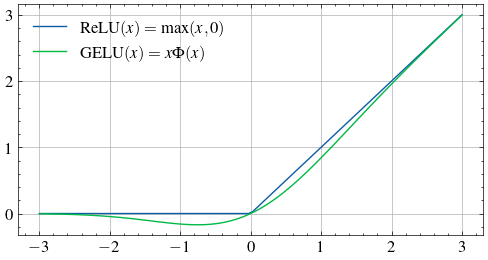

In [11]:
import torch
from torch.nn.functional import relu, gelu

fig, ax = plt.subplots(figsize=(6, 3))

x = torch.linspace(-3, 3, 100)
ax.plot(x, relu(x), label='ReLU$(x) =$ max$(x, 0)$')
ax.plot(x, gelu(x), label='GELU$(x) = x\Phi(x)$')

ax.legend()
ax.grid()
fig.savefig('figures/relugelu.pdf')

In [3]:
images = [Image.open(image_dir / f'{id}.jpg').convert('L') for id in tqdm(annotations.ID)]
profiles = [pd.read_csv(profile_dir / f'{id}.csv') for id in tqdm(annotations.ID)]



100%|██████████| 20050/20050 [00:10<00:00, 1894.50it/s]


In [5]:
size = np.array([image.size for image in images])
lengths = np.array([len(profile) for profile in profiles])


NameError: name 'images' is not defined

In [1]:

profiles[0].min()

NameError: name 'profiles' is not defined

In [207]:
sample = annotations.iloc[243]

orig = Image.open(image_dir / f'{sample.ID}.jpg')

img = data.resize(orig.crop((0, 20, *orig.size)), target_res=224)

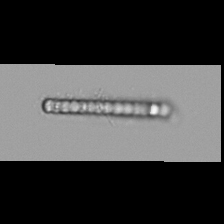

In [478]:
v2.RandomAffine(degrees=2, translate=(0.02, 0.02), scale=(0.98, 1.02))(img)

In [3]:
lens = [pd.read_csv(file).shape[0] for file in tqdm(list(profile_dir.iterdir()))]

100%|██████████| 20050/20050 [00:27<00:00, 722.04it/s]


In [4]:
counter = Counter(lens)

In [ ]:
def foo(file):
    profile = np.loadtxt(file, delimiter=',', skiprows=1)  
    profile = torch.tensor(profile)
    l = profile.size(0)
    d = random.randint(0, 5)
    return l+d


In [30]:
from torch.utils.data import Dataset, DataLoader


class Foo(Dataset):
    
    def __init__(self, files):
        super().__init__()
        self.files = files
    def __getitem__(self, index):
        profile = np.loadtxt(self.files[index], delimiter=',', skiprows=1)  
        profile = torch.tensor(profile)
        l = profile.size(0)
        d = random.randint(-10, 10)
        return l+d
    def __len__(self):
        return len(self.files)


foo = Foo(sorted(profile_dir.iterdir()))

In [31]:
counter = Counter()
loader = DataLoader(foo, 128, num_workers=4)
lens_rand = []

for _ in range(10):
    for oof in tqdm(loader):
        lens_rand.extend(list(oof))

100%|██████████| 157/157 [00:01<00:00, 115.56it/s]


In [32]:
# plot_params = np.array(list(counter.items())).T
# print(plot_params, plot_params.shape)

plot_params = np.stack(np.unique(lens_rand, return_counts=True))

In [35]:
np.diff(plot_params[0])

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

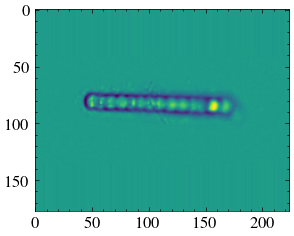

In [73]:
image = v2.functional.to_image(orig)
image = v2.functional.to_dtype(image, scale=True)
image = image[:, 20:]
size = image.shape[1:]
image = v2.functional.resize(image, math.ceil(min(size) * 224 / max(size)))
plt.imshow(v2.functional.pad(image, (0, 40), padding_mode='edge')[0])


In [2]:
root = Path('./data/CytoSense')
img_path = root / 'images'          # image data
mod_path = root / 'profiles'        # optical profiles
annot_path = root / 'annotations.csv'
orig_path = root / 'Pulse-shapes_annotated_CS_images.csv'

pattern = str(root / '**' / '*.jpg')
image_paths = glob.glob(pattern, recursive=True)

def fun(path):
    file = path.replace(str(root) + '/', '')
    return (
        file.rsplit('/', 1)[-1].replace('_Cropped_With_Scalebar', '')[:-4],
        {
            'class': file.split('/', 1)[0],
            'image': file
        }
    )
    
lookup = dict(map(fun, image_paths))

In [30]:
len(lookup)

14279

In [5]:
scan_args = dict(separator=' ',
                schema_overrides={'FWS': pl.Float32, 'SWS': pl.Float32,
                                  'FL.Green': pl.Float32,  'FL.Yellow': pl.Float32, 
                                  'FL.Orange': pl.Float32, 'FL.Red': pl.Float32},
                null_values=['NA'],
                low_memory=True)

df = (
    pl.concat((
        pl.scan_csv(root / 'PDexp_Micro_phyto_pulse-shapes.txt', **scan_args),
        pl.scan_csv(root / 'Uto_2020_pulse-shapes.txt', **scan_args)
    ))
        .drop_nulls()
        .filter((pl.col('ID') > 0), pl.concat_str(pl.col('Sample'), pl.col('ID'), separator='_').is_in(lookup))
        .group_by('ID', 'Sample')
        .agg(pl.col('FWS', 'SWS', 'FL.Green', 'FL.Yellow', 'FL.Orange', 'FL.Red'))
        .sort('ID', 'Sample')
).collect()

In [31]:
df

ID,Sample,FWS,SWS,FL.Green,FL.Yellow,FL.Orange,FL.Red
i64,str,list[f32],list[f32],list[f32],list[f32],list[f32],list[f32]
1,"""UtoF_FLR_L 2020-07-09 21h20""","[9.542, 13.66, … 49.169998]","[64.0, 83.25, … 88.669998]","[4.458, 2.375, … 0.9167]","[8.458, 5.75, … 7.667]","[3.458, 6.281, … 8.083]","[43.0, 49.5, … 60.0]"
1,"""UtoF_FLR_L 2020-07-10 08h20""","[29.75, 41.5, … 208.0]","[174.699997, 269.0, … 99.330002]","[22.5, 21.0, … 0.7917]","[5.458, 5.906, … 13.08]","[6.708, 8.875, … 36.330002]","[45.0, 54.25, … 68.669998]"
2,"""UtoF_FLR_L 2020-07-09 04h10""","[17.540001, 19.0, … 164.0]","[9.25, 11.13, … 100.699997]","[24.5, 17.969999, … 15.75]","[10.75, 13.06, … 22.5]","[23.17, 26.25, … 61.330002]","[57.669998, 60.25, … 72.669998]"
2,"""UtoF_FLR_L 2020-07-09 16h10""","[3.708, 4.688, … 28.17]","[11.75, 14.81, … 47.669998]","[22.17, 22.75, … 13.58]","[16.92, 13.19, … 19.5]","[10.08, 7.0, … 11.42]","[60.0, 69.25, … 78.0]"
2,"""UtoF_FLR_L 2020-07-09 23h20""","[22.58, 26.280001, … 110.0]","[142.699997, 148.0, … 153.300003]","[18.17, 17.690001, … 4.042]","[7.167, 8.406, … 28.83]","[12.92, 11.75, … 40.330002]","[45.0, 50.5, … 61.330002]"
…,…,…,…,…,…,…,…
26955,"""PD_01_D2_FLR_L 2020-09-10 07h1…","[19.5, 29.809999, … 115.699997]","[45.669998, 64.75, … 193.300003]","[10.75, 12.75, … 3.125]","[5.292, 3.688, … 4.333]","[2.708, 3.969, … 3.708]","[29.33, 38.380001, … 51.669998]"
27107,"""PD_04_D2_FLR_L 2020-09-10 08h2…","[10.88, 11.09, … 4.583]","[130.699997, 138.5, … 86.0]","[10.75, 12.5, … 10.08]","[0.0, 0.875, … 7.167]","[2.75, 2.094, … 0.5833]","[68.669998, 73.0, … 92.669998]"
27512,"""PD_09_D2_FLR_L 2020-09-10 10h0…","[160.699997, 214.800003, … 205.300003]","[261.299988, 335.0, … 125.300003]","[0.0, 0.3125, … 12.0]","[19.5, 26.629999, … 23.17]","[32.0, 42.630001, … 50.330002]","[35.330002, 46.630001, … 51.0]"


In [79]:
imgs = []
profs = []
classes = []

for id, sample, fws, sws, green, yellow, orange, red in df.rows():
    key = f'{sample}_{id}'
    img_path = lookup[key]['image']
    prof_path = img_path.replace('Cropped_With_Scalebar', 'Profile').replace('jpg', 'csv')
    imgs.append(img_path)
    profs.append(prof_path)
    classes.append(lookup[key]['class'])
    profile = pl.DataFrame(
        {
           'FSC': fws,
           'SSC': sws,
           'Green': green,
           'Yellow': yellow,
           'Orange': orange,
           'Red': red
        }
    )
    profile.write_csv(root / prof_path)

annotations = pl.DataFrame(
    {
        'image': imgs,
        'profile': profs,
        'class': classes
    }
).sort('class', 'image')
annotations.write_csv(root / 'annotations.csv')

In [80]:
annotations

image,profile,class
str,str,str
"""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae"""
"""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae"""
"""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae"""
"""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae"""
"""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae/202b_F…","""Aphanizomenon_flosaquae"""
…,…,…
"""Snowella-Woronichinia/Loose/PD…","""Snowella-Woronichinia/Loose/PD…","""Snowella-Woronichinia"""
"""Snowella-Woronichinia/Loose/PD…","""Snowella-Woronichinia/Loose/PD…","""Snowella-Woronichinia"""
"""Snowella-Woronichinia/Loose/PD…","""Snowella-Woronichinia/Loose/PD…","""Snowella-Woronichinia"""


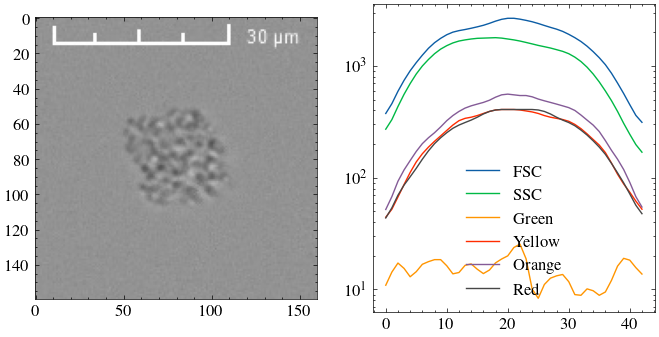

In [102]:
_, ax = plt.subplots(1, 2, figsize=(8,4))

sample = annotations[2000]

ax[0].imshow(Image.open(root / sample['image'].item()))
pd.read_csv(root / sample['profile'].item()).plot(ax=ax[1])
ax[1].set_yscale('log')

In [32]:
kwargs = dict(schema_overrides={'FWS': pl.Float32, 'SWS': pl.Float32,
                                  'FL.Green': pl.Float32,  'FL.Yellow': pl.Float32, 
                                  'FL.Orange': pl.Float32, 'FL.Red': pl.Float32},
              null_values=['NA'],
              low_memory=True)
(
    pl.scan_csv(orig_path, **kwargs)
        .drop_nulls()
        .group_by('X', 'classes')
        .agg(pl.col('FWS', 'SWS', 'FL.Green', 'FL.Yellow', 'FL.Orange', 'FL.Red'))
        .sort('X')
).collect()


X,classes,FWS,SWS,FL.Green,FL.Yellow,FL.Orange,FL.Red
i64,str,list[f32],list[f32],list[f32],list[f32],list[f32],list[f32]
2,"""Aphanizomenon_flosaquae""","[55.330002, 77.0, … 117.0]","[773.299988, 904.0, … 413.299988]","[9.917, 15.53, … 20.5]","[5.75, 6.281, … 7.25]","[41.0, 47.0, … 78.0]","[46.330002, 55.75, … 76.669998]"
3,"""Aphanizomenon_flosaquae""","[1064.0, 1064.0, … 34.169998]","[2037.0, 2148.0, … 198.699997]","[2.542, 7.0, … 10.75]","[7.167, 4.438, … 1.042]","[86.0, 93.0, … 30.67]","[122.0, 124.5, … 37.0]"
4,"""Aphanizomenon_flosaquae""","[42.0, 52.220001, … 92.0]","[1264.0, 1360.0, … 656.0]","[2.458, 4.25, … 11.75]","[0.0, 0.8438, … 22.5]","[37.669998, 44.0, … 43.669998]","[78.0, 89.0, … 88.669998]"
5,"""Aphanizomenon_flosaquae""","[68.669998, 98.0, … 573.299988]","[1232.0, 1604.0, … 965.299988]","[12.67, 15.31, … 22.5]","[0.0, 0.8125, … 7.333]","[43.0, 54.75, … 94.0]","[47.0, 64.75, … 116.699997]"
8,"""Aphanizomenon_flosaquae""","[682.700012, 672.0, … 35.830002]","[1509.0, 1648.0, … 349.299988]","[6.292, 7.094, … 12.58]","[11.25, 10.22, … 14.0]","[31.33, 46.380001, … 35.330002]","[50.330002, 63.25, … 44.330002]"
…,…,…,…,…,…,…,…
14284,"""Small centric""","[410.700012, 568.5, … 465.299988]","[322.700012, 450.0, … 386.700012]","[14.92, 13.75, … 11.42]","[6.458, 7.344, … 6.542]","[9.667, 7.063, … 5.75]","[22.17, 33.880001, … 47.669998]"
14286,"""Small centric""","[24.08, 35.880001, … 163.699997]","[185.300003, 245.0, … 624.0]","[0.0, 2.063, … 4.875]","[6.0, 7.375, … 7.417]","[6.583, 4.438, … 4.625]","[22.67, 35.630001, … 53.669998]"
14288,"""Small centric""","[110.300003, 155.5, … 441.299988]","[190.699997, 253.0, … 560.0]","[3.0, 4.781, … 10.58]","[0.7917, 1.375, … 1.375]","[9.417, 9.063, … 6.958]","[26.67, 35.130001, … 57.669998]"


In [104]:
df[0].explode(pl.col('FWS'), pl.col('SWS'), pl.col('FL.Green'),
              pl.col('FL.Yellow'), pl.col('FL.Orange'), pl.col('FL.Red'))

ID,Sample,FWS,SWS,FL.Green,FL.Yellow,FL.Orange,FL.Red
i64,str,f32,f32,f32,f32,f32,f32
1,"""UtoF_FLR_L 2020-07-09 21h20""",9.542,64.0,4.458,8.458,3.458,43.0
1,"""UtoF_FLR_L 2020-07-09 21h20""",13.66,83.25,2.375,5.75,6.281,49.5
1,"""UtoF_FLR_L 2020-07-09 21h20""",22.030001,114.5,0.4688,4.406,10.22,64.75
1,"""UtoF_FLR_L 2020-07-09 21h20""",36.130001,149.5,1.969,7.438,12.88,88.25
1,"""UtoF_FLR_L 2020-07-09 21h20""",59.810001,197.0,8.813,12.94,13.63,121.5
…,…,…,…,…,…,…,…
1,"""UtoF_FLR_L 2020-07-09 21h20""",81.629997,190.0,12.06,2.938,8.031,107.0
1,"""UtoF_FLR_L 2020-07-09 21h20""",66.129997,144.5,7.063,7.0,6.813,91.0
1,"""UtoF_FLR_L 2020-07-09 21h20""",57.0,113.5,2.063,10.41,7.156,78.0


In [33]:
(
    pl.scan_csv(annot_path, separator=' ',
                schema_overrides={'FWS': pl.Float32, 'SWS': pl.Float32,
                                  'FL.Green': pl.Float32, 'FL.Yellow': pl.Float32, 
                                  'FL.Orange': pl.Float32, 'FL.Red': pl.Float32},
                null_values=['NA'])
    # .head(10000)
    .drop_nulls()
    .filter((pl.col('ID') > 0) & (pl.col('ID').is_in(image_ids)) & (pl.col('Sample').is_in(image_samples)))
    .group_by('ID', 'Sample')
    .agg([pl.col('FWS'), pl.col('SWS'), pl.col('FL.Green'),
          pl.col('FL.Yellow'), pl.col('FL.Orange'), pl.col('FL.Red')])
    .collect()
)

FileNotFoundError: No such file or directory (os error 2): data/CytoSense/annotations.csv

This error occurred with the following context stack:
	[1] 'csv scan'
	[2] 'filter'
	[3] 'filter'
	[4] 'group_by'
	[5] 'sink'


In [44]:
for foo in df['cluster'].unique().sort():
    print(foo)

Aphanizomenon
Chain
Crypto_PC
Crypto_PE_L
Crypto_PE_M
Crypto_PE_S
Cyano_PC_Fil
Cyano_PC_S
Cyano_PE_L
Cyano_PE_S
Monor
NF1
NF2
NF3
NF4
NF5
NF6
NF7
NF_10up
Oocystis
Pennate
Pico_euk1
Pico_pro1


(array([], dtype=int64),)


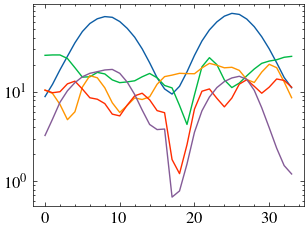

In [17]:
data = np.stack(list(df[0, 2:7].to_numpy()[0])).T
print(np.where((data == 0).any(1)))
plt.plot(data)
plt.yscale('log')

In [16]:
ids = table.ID
list(table.groupby('ID'))

: 

In [ ]:
table.ID !=

1             192
2             192
3             192
4             192
5             192
            ...  
38854511    10839
38854512    10839
38854513    10839
38854514        0
38854515        0
Name: ID, Length: 38854515, dtype: int64

In [9]:
dirs = filter(Path.is_dir, data_dir.iterdir())
files = []
for directory in dirs: 
    files.extend(directory.glob('*.jpg'))

len(files)
files

[PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-15 12h16_Cropped_With_Scalebar_985.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 00h16_Cropped_With_Scalebar_465.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 15h16_Cropped_With_Scalebar_1055.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 03h16_Cropped_With_Scalebar_768.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-09 02h10_Cropped_With_Scalebar_1584.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 12h16_Cropped_With_Scalebar_150.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-15 03h16_Cropped_With_Scalebar_130.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-14 13h16_Cropped_With_Scalebar_613.jpg'),
 PosixPath('data/CytoSense/Ceratoconeis closterion/UtoF_FLR_L 2020-07-13 09h16_Cropped_With_Scalebar_6

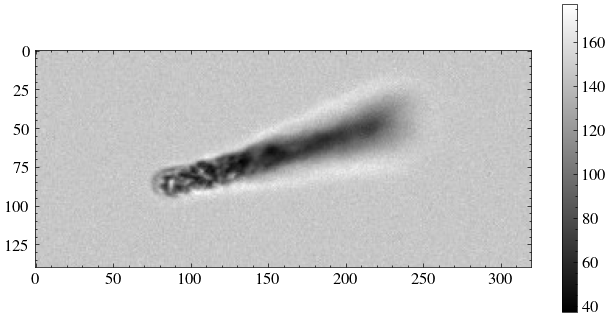

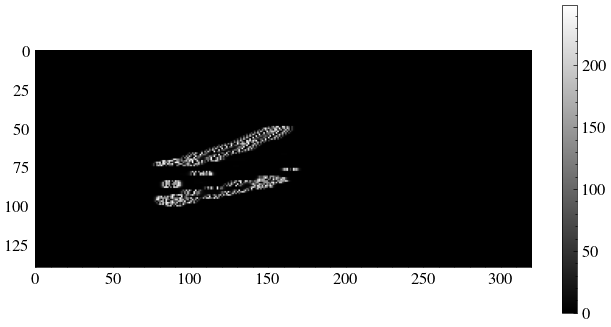

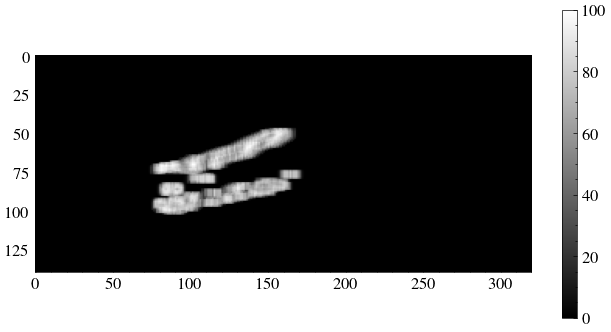

In [52]:
import scipy.ndimage


file_name = 'data/CytoSense/Annotated_CS_images/Aphanizomenon_flosaquae/UtoF_FLR_L 2020-07-09 13h10_Cropped_With_Scalebar_461.jpg'

img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
img = img[20:]

plt.figure(figsize=(8, 4))
plt.imshow(img, cmap='gray')
plt.colorbar()

laplacian = scipy.ndimage.gaussian_laplace(img, 3)**2
# laplacian = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min())


plt.figure(figsize=(8, 4))
plt.imshow(laplacian, cmap='gray')
plt.colorbar()

def filt(window):
    return window.std()

stds = scipy.ndimage.generic_filter(laplacian, filt, 5)

plt.figure(figsize=(8, 4))
plt.imshow(stds, cmap='gray')
plt.colorbar()